# Comparison of library strategies

We aim at comparing how different is the variant calling outcome depending on the library strategy employed.
For this purpose we will use samples obtained from ENA (last queried 09/10/2021, n=48,844 samples) sequenced with Illumina technology using three library strategies: WGS, WGA and targeted-capture.
The SARS-CoV-2 ENA dataset is imperfect for this purpose as we don't have the same samples sequenced with different strategies.
Furthermore, we expect a high heterogeneity between sequencing centers across the globe using the same library strategy.

We aim to look at two factors: 1) mutations and 2) coverage.

Regarding 1) we are interested in understanding:
* Overall number of mutations per sample
* Unique mutations for each technology
* Focused geographical and temporal analysis to minimise expected variability in SARS-CoV-2

Regarding 2) we are interested in understanding:
* How depth of coverage differs between technologies
* How breadth of coverage differs between technologies
* Are there any blind spots of a particular technology?

In [286]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import upsetplot
sns.set_context("notebook")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Data loading

In [235]:
local_base_folder = "/home/priesgo/tronland"  # replace this by "/" if running on tronland
data_folder = os.path.join(local_base_folder, "scratch/info/projects/covigator/data/db_dump_20211102")
sample_table = os.path.join(data_folder, "sample_ena.csv.gz")
jobs_table = os.path.join(data_folder, "job_ena.csv.gz")
genes_table = os.path.join(data_folder, "gene.csv")
variants_table = os.path.join(data_folder, "variant_observation_only_ena.csv.gz")

In [5]:
samples = pd.read_csv(sample_table)
samples.head()

,run_accession,finished,sample_accession,scientific_name,study_accession,experiment_accession,first_created,collection_date,instrument_platform,instrument_model,...,country_alpha_2,country_alpha_3,continent,continent_alpha_2,count_snvs,count_insertions,count_deletions,count_subclonal_snvs,count_subclonal_insertions,count_subclonal_deletions
0,ERR6356167,f,SAMEA8993004,Severe acute respiratory syndrome coronavirus 2,PRJEB43166,ERX5987718,2021-07-23,2021-07-03,ILLUMINA,Illumina MiSeq,...,ES,ESP,Europe,EU,NaN,NaN,NaN,NaN,NaN,NaN
1,ERR6360438,t,SAMEA8995531,Severe acute respiratory syndrome coronavirus 2,PRJEB43166,ERX5991972,2021-07-26,2021-06-26,ILLUMINA,Illumina MiSeq,...,ES,ESP,Europe,EU,34.0,0.0,3.0,47.0,77.0,27.0
2,ERR6356169,t,SAMEA8993006,Severe acute respiratory syndrome coronavirus 2,PRJEB43166,ERX5987720,2021-07-23,2021-07-03,ILLUMINA,Illumina MiSeq,...,ES,ESP,Europe,EU,35.0,0.0,4.0,33.0,76.0,35.0
3,ERR6360437,t,SAMEA8995530,Severe acute respiratory syndrome coronavirus 2,PRJEB43166,ERX5991971,2021-07-26,2021-06-26,ILLUMINA,Illumina MiSeq,...,ES,ESP,Europe,EU,34.0,0.0,3.0,47.0,125.0,52.0
4,ERR6360435,t,SAMEA8995528,Severe acute respiratory syndrome coronavirus 2,PRJEB43166,ERX5991969,2021-07-26,2021-06-26,ILLUMINA,Illumina MiSeq,...,ES,ESP,Europe,EU,33.0,0.0,3.0,34.0,109.0,35.0


In [6]:
jobs = pd.read_csv(jobs_table)
jobs.head()

,run_accession,status,created_at,queued_at,downloaded_at,analysed_at,cleaned_at,loaded_at,cooccurrence_at,failed_at,...,vcf_path,qc_path,horizontal_coverage_path,vertical_coverage_path,num_reads,covered_bases,coverage,mean_depth,mean_base_quality,mean_mapping_quality
0,ERR6542323,FINISHED,2021-08-27 08:49:27.078335+02,2021-09-28 22:05:37.516373+02,2021-09-29 03:57:10.596071+02,2021-09-29 04:04:19.620247+02,NaN,2021-09-29 04:04:21.165466+02,2021-09-29 04:04:24.839144+02,2021-09-28 21:44:56.926702+02,...,/scratch/info/projects/covigator/data/ena/ERR6...,/scratch/info/projects/covigator/data/ena/ERR6...,/scratch/info/projects/covigator/data/ena/ERR6...,/scratch/info/projects/covigator/data/ena/ERR6...,28035.0,29903.0,100.0000,132.765,35.9,60.0
1,SRR16040540,FAILED_PROCESSING,2021-09-29 20:34:58.832106+02,2021-10-09 10:42:12.908603+02,NaN,NaN,NaN,NaN,NaN,2021-10-10 03:48:08.66686+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SRR12380016,EXCLUDED,2021-10-09 09:03:31.296565+02,2021-10-09 10:39:59.981645+02,NaN,NaN,NaN,NaN,NaN,2021-10-09 19:37:38.904806+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SRR12733630,EXCLUDED,2021-10-09 09:03:31.296565+02,2021-10-09 10:39:56.968163+02,NaN,NaN,NaN,NaN,NaN,2021-10-09 20:03:07.516184+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ERR6445714,FINISHED,2021-08-27 08:49:27.078335+02,2021-09-28 22:05:37.585955+02,2021-09-29 03:58:28.207788+02,2021-09-29 04:04:42.919961+02,NaN,2021-09-29 04:04:43.863973+02,2021-09-29 04:04:47.498311+02,2021-09-28 21:44:58.181657+02,...,/scratch/info/projects/covigator/data/ena/ERR6...,/scratch/info/projects/covigator/data/ena/ERR6...,/scratch/info/projects/covigator/data/ena/ERR6...,/scratch/info/projects/covigator/data/ena/ERR6...,2133.0,28584.0,95.5891,15.115,35.5,60.0


In [21]:
variants = pd.read_csv(variants_table)
variants.head()

,source,sample,variant_id,chromosome,position,reference,alternate,quality,filter,dp,...,variant_type,length,reference_amino_acid,alternate_amino_acid,position_amino_acid,cons_hmm_sars_cov_2,cons_hmm_sarbecovirus,cons_hmm_vertebrate_cov,pfam_name,pfam_description
0,ENA,ERR6426655,26217:G>T,MN908947.3,26217,G,T,41200.0,NaN,1194.0,...,SNV,0,L,F,275.0,-0.35633,-0.35633,0.00000,NaN,NaN
1,ENA,ERR6405909,21301:C>A,MN908947.3,21301,C,A,16308.0,NaN,443.0,...,SNV,0,N,K,7012.0,0.00000,0.57215,-0.72839,CoV_Methyltr_2,"Non-structural protein NSP16, coronavirus-like"
2,ENA,ERR6424166,26424:T>C,MN908947.3,26424,T,C,49314.0,NaN,1655.0,...,SNV,0,NaN,NaN,NaN,0.00000,0.00000,0.00000,CoV_E,"Envelope small membrane protein, coronavirus"
3,ENA,ERR6424166,24334:C>T,MN908947.3,24334,C,T,13602.0,NaN,387.0,...,SNV,0,NaN,NaN,NaN,-0.72839,0.00000,-0.72839,CoV_S2,"Spike glycoprotein S2, coronavirus"
4,ENA,ERR6412149,1684:C>T,MN908947.3,1684,C,T,30130.0,NaN,832.0,...,SNV,0,NaN,NaN,NaN,-1.04511,-1.04511,0.00000,NaN,NaN


### Data filtering criteria

We exclude samples from other strategy than WGA, WGS or targeted-capture; in particular due to historical reasons we have in our table RNA-Seq samples. Furthermore, samples that failed to be processed by the pipeline or that were excluded due to quality criteria.

In [9]:
samples = pd.merge(samples, jobs, on="run_accession")

In [13]:
samples.status.value_counts()

FINISHED             48844
EXCLUDED              6230
FAILED_PROCESSING     4701
Name: status, dtype: int64

In [14]:
samples.finished.value_counts()

t    48844
f    10931
Name: finished, dtype: int64

In [18]:
samples = samples[samples.finished == "t"]

In [19]:
samples.status.value_counts()

FINISHED    48844
Name: status, dtype: int64

In [22]:
variants.shape

(969319, 34)

In [24]:
variants = variants[variants["sample"].isin(samples.run_accession)]
variants.shape

(969148, 34)

## Use of library strategies through time

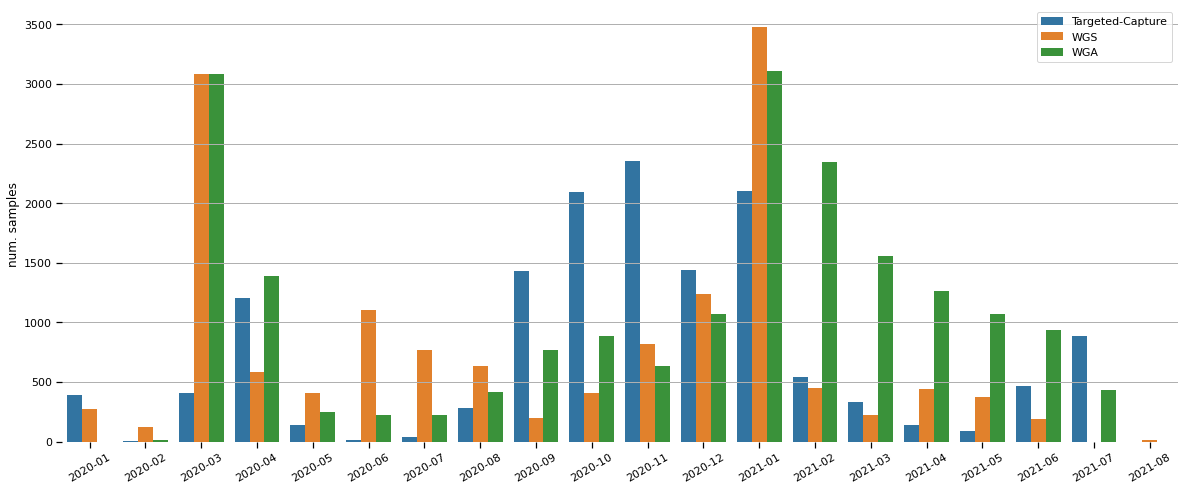

In [311]:
samples["month"] = pd.to_datetime(samples.collection_date, format='%Y-%m-%d', errors='coerce').dt.to_period('m')
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
splot = sns.barplot(data=samples[["library_strategy", "run_accession", "month"]].groupby(["month", "library_strategy"]).count().reset_index(), 
            y="run_accession", x="month", hue='library_strategy')
plt.xticks(rotation=30)
ax.legend(loc='upper right')
splot.set(xlabel=None, ylabel=None)
sns.despine(bottom=True, left=True)
plt.ylabel("num. samples")
plt.grid(axis="y")
fig.savefig("figure_00_distribution_samples_through_time_by_library_strategy.jpg", dpi=200)

## Number of mutations per sample

We found an outlier WGA sample having 162 mutations, the next sample with more mutation has less than 60 mutations.
We will exclude this sample from further analysis.

We normalise the number of samples by the total number of samples.

We observed three peaks in number of mutations at just below 10 mutations, just below 20 mutations and just below 40 mutations. 
The third peak is observed for the three library strategies. The first and and second peaks show more variability.
The library strategy more different from the others in terms of number of mutations is the targeted capture, which would make sense if the targeted region is very different.

In [33]:
variants_per_sample = variants[["sample", "variant_id"]].groupby("sample").count().reset_index()
variants_per_sample = pd.merge(variants_per_sample, samples[["run_accession", "library_strategy"]], left_on="sample", right_on="run_accession")
del variants_per_sample["run_accession"]
variants_per_sample.head()

,sample,variant_id,library_strategy
0,DRR287659,1,WGS
1,DRR287660,1,WGS
2,DRR287661,1,WGS
3,DRR287662,1,WGS
4,DRR287663,3,WGS


In [36]:
num_samples_per_variant_count = variants_per_sample.groupby(["library_strategy", "variant_id"]).count().reset_index()
num_samples_per_variant_count.head()

,library_strategy,variant_id,sample
0,Targeted-Capture,1,151
1,Targeted-Capture,2,164
2,Targeted-Capture,3,170
3,Targeted-Capture,4,213
4,Targeted-Capture,5,263


In [46]:
count_samples_by_library_strategy = samples.library_strategy.value_counts().reset_index().rename(
    columns={"index": "library_strategy", "library_strategy": "total_samples"})
count_samples_by_library_strategy

,library_strategy,total_samples
0,WGA,19660
1,WGS,14825
2,Targeted-Capture,14359


In [48]:
num_samples_per_variant_count = pd.merge(num_samples_per_variant_count, count_samples_by_library_strategy, on="library_strategy")
num_samples_per_variant_count["sample_normalised"] = num_samples_per_variant_count["sample"] / num_samples_per_variant_count["total_samples"]
num_samples_per_variant_count.head()

,library_strategy,variant_id,sample,total_samples,sample_normalised
0,Targeted-Capture,1,151,14359,0.010516
1,Targeted-Capture,2,164,14359,0.011421
2,Targeted-Capture,3,170,14359,0.011839
3,Targeted-Capture,4,213,14359,0.014834
4,Targeted-Capture,5,263,14359,0.018316


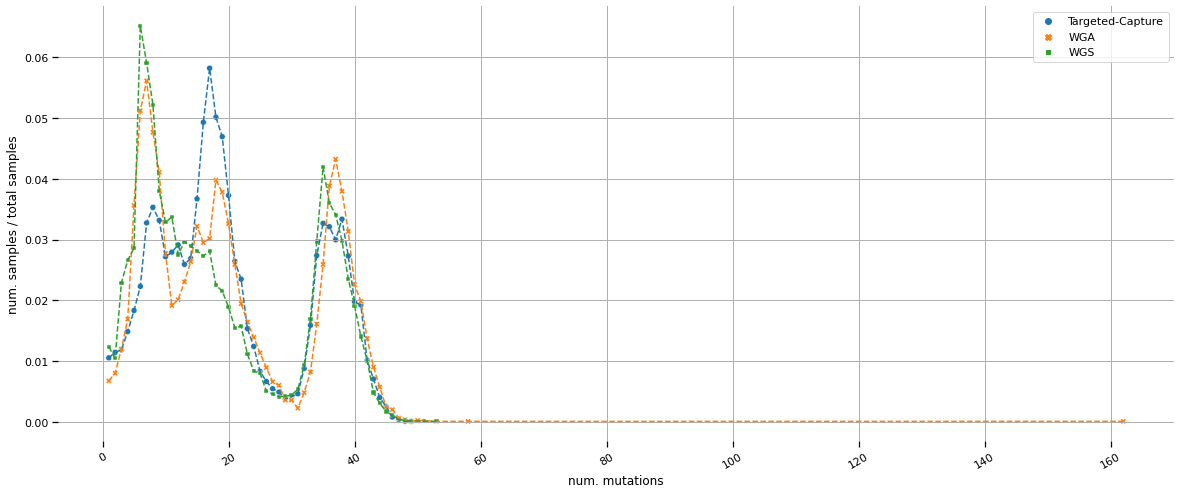

In [312]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=num_samples_per_variant_count, x="variant_id", y="sample_normalised", hue="library_strategy", legend=False, linestyle="--")
sns.scatterplot(data=num_samples_per_variant_count, x="variant_id", y="sample_normalised", hue="library_strategy", style="library_strategy", legend=True)
plt.xticks(rotation=30)
plt.title("")
plt.ylabel("num. samples / total samples")
plt.xlabel("num. mutations")
plt.legend(title=None)
plt.grid(axis="x")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig("figure_01_mutations_per_sample_distribution.png")

In [39]:
num_samples_per_variant_count[num_samples_per_variant_count.variant_id > 100]

,library_strategy,variant_id,sample
101,WGA,162,1


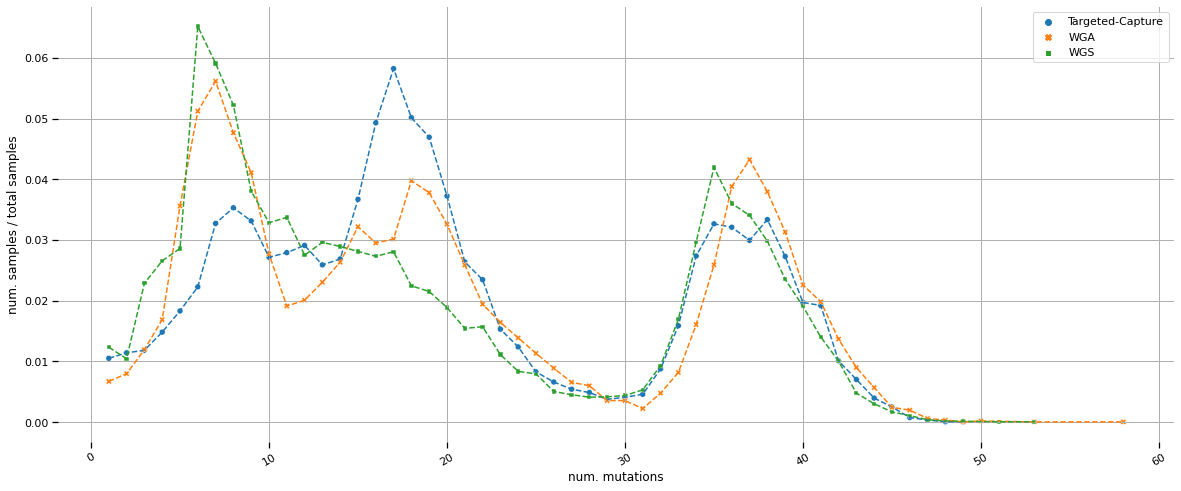

In [313]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=num_samples_per_variant_count[num_samples_per_variant_count.variant_id < 100], 
             x="variant_id", y="sample_normalised", hue="library_strategy", legend=False, linestyle="--")
sns.scatterplot(data=num_samples_per_variant_count[num_samples_per_variant_count.variant_id < 100], 
                x="variant_id", y="sample_normalised", hue="library_strategy", style="library_strategy", legend=True)
plt.xticks(rotation=30)
plt.title("")
plt.ylabel("num. samples / total samples")
plt.xlabel("num. mutations")
plt.legend(title=None)
plt.grid(axis="x")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig("figure_01_mutations_per_sample_distribution_wo_outliers.png")

## Unique mutations

<Figure size 1440x576 with 0 Axes>

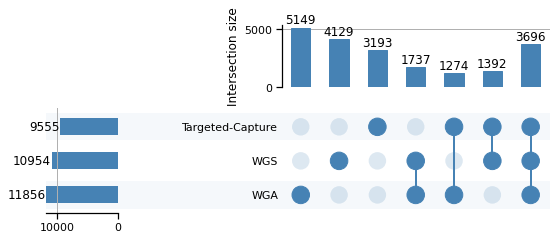

In [291]:
data=pd.merge(variants, samples[["run_accession", "library_strategy"]], left_on="sample", right_on="run_accession")
annotations=[]
table = data.groupby(['variant_id', 'library_strategy']).size().unstack(fill_value=0).astype(bool)
all_afs = data.set_index(['variant_id'])
all_afs = all_afs.loc[~all_afs.index.duplicated(keep='first')]
table = table.reset_index().join(all_afs, how='inner', on=['variant_id'])
table = table.set_index(list(set(data.library_strategy)))

plt.figure(figsize=(20, 8))
upset = upsetplot.UpSet(table, subset_size='count', intersection_plot_elements=2, facecolor='steelblue', show_counts=True, element_size=50)
colors= ['orange', 'forestgreen', 'indianred']
for a, c in zip(annotations, colors):
        upset.add_catplot(value=a, kind='strip', color=c, alpha=0.4)
fig = plt.figure(figsize=(300,100))
upset.plot(fig=fig)
fig.savefig("figure_02_upset.png")

## Focused geographical and temporal analysis

In [297]:
top_10_countries = list(samples.country.value_counts().head(10).reset_index()["index"])
samples.country.value_counts().head(10).reset_index()

,index,country
0,Spain,18631
1,United Kingdom,17720
2,United States,5750
3,India,2003
4,Switzerland,1755
5,Poland,901
6,Brazil,394
7,Peru,355
8,Greece,320
9,Qatar,242


<Figure size 1440x576 with 0 Axes>

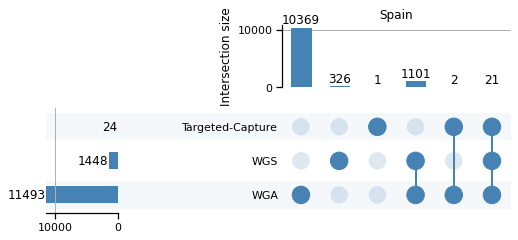

<Figure size 1440x576 with 0 Axes>

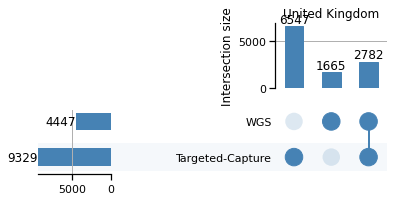

<Figure size 1440x576 with 0 Axes>

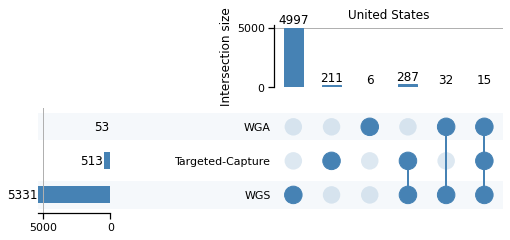

<Figure size 1440x576 with 0 Axes>

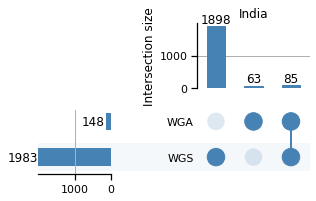

<Figure size 1440x576 with 0 Axes>

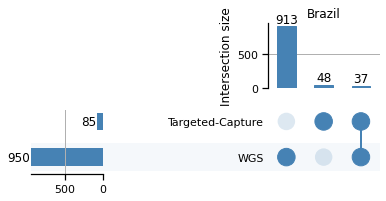

<Figure size 1440x576 with 0 Axes>

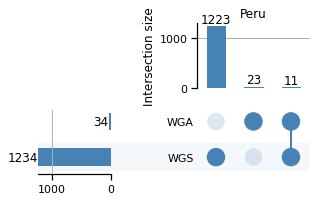

In [307]:
for country in top_10_countries:
    data = pd.merge(variants, samples[["run_accession", "library_strategy", "country"]], left_on="sample", right_on="run_accession")
    data = data[data.country == country]
    if len(data.library_strategy.unique()) > 1:
        annotations=[]
        table = data.groupby(['variant_id', 'library_strategy']).size().unstack(fill_value=0).astype(bool)
        all_afs = data.set_index(['variant_id'])
        all_afs = all_afs.loc[~all_afs.index.duplicated(keep='first')]
        table = table.reset_index().join(all_afs, how='inner', on=['variant_id'])
        table = table.set_index(list(set(data.library_strategy)))

        plt.figure(figsize=(20, 8))
        upset = upsetplot.UpSet(table, subset_size='count', intersection_plot_elements=2, facecolor='steelblue', show_counts=True, element_size=50)
        colors= ['orange', 'forestgreen', 'indianred']
        for a, c in zip(annotations, colors):
                upset.add_catplot(value=a, kind='strip', color=c, alpha=0.4)
        fig = plt.figure(figsize=(300,100))
        upset.plot(fig=fig)
        plt.title(country)
        fig.savefig("figure_03_upset_by_country_{}.png".format(country.replace(" ", "_")))

## Depth of coverage

The median depth of coverage is of 1171X for WGA, 247X for targeted capture and 132X for WGS.

In [141]:
samples.mean_depth.describe()

count    48844.000000
mean      1228.172768
std       2242.075216
min          0.285323
25%         90.363550
50%        898.076000
75%       1425.570000
max      49611.600000
Name: mean_depth, dtype: float64

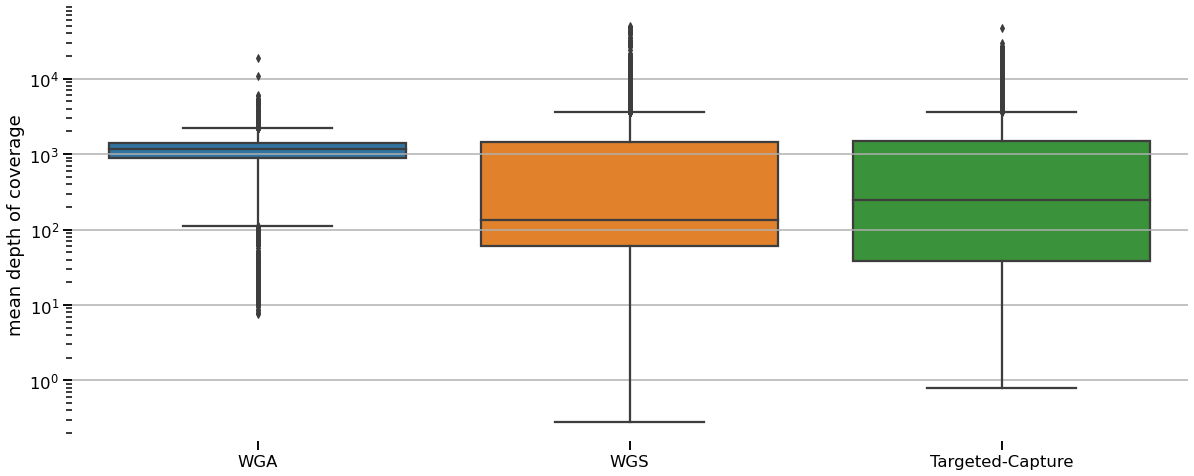

In [146]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=samples, y="mean_depth", x="library_strategy")
plt.title("")
plt.xlabel(None)
plt.ylabel("mean depth of coverage")
plt.grid(axis="y")
plt.yscale("log")
sns.despine(bottom=True, left=True)
plt.savefig("figure_04_width_coverage_boxplot.png")

In [147]:
samples[samples.library_strategy == "WGA"].mean_depth.describe()

count    19660.000000
mean      1113.907024
std        548.591644
min          7.603890
25%        894.385000
50%       1170.870000
75%       1416.390000
max      18556.200000
Name: mean_depth, dtype: float64

In [148]:
samples[samples.library_strategy == "WGS"].mean_depth.describe()

count    14825.000000
mean       968.182174
std       2103.706289
min          0.285323
25%         60.255600
50%        132.046000
75%       1462.310000
max      49611.600000
Name: mean_depth, dtype: float64

In [149]:
samples[samples.library_strategy == "Targeted-Capture"].mean_depth.describe()

count    14359.000000
mean      1653.050897
std       3442.529671
min          0.788249
25%         38.295250
50%        247.400000
75%       1487.755000
max      47461.900000
Name: mean_depth, dtype: float64

## Breadth of coverage

We found that the library strategy with highest breadth of coverage across all samples was the targeted sequencing with a median of 99.9498, followed by WGS with 99.7492 and WGA with 99.0.

In [92]:
samples.coverage.describe()

count    48844.000000
mean        98.272006
std          6.403529
min         20.000000
25%         99.000000
50%         99.762600
75%         99.923100
max        100.000000
Name: coverage, dtype: float64

In [93]:
# bins coverage with bin size 5 %
samples["coverage_binned"] = pd.cut(samples.coverage, bins=range(0, 101, 5))

count         48844
unique           17
top       (95, 100]
freq          46167
Name: coverage_binned, dtype: object

In [104]:
num_samples_by_breadth_coverage = samples[["run_accession", "library_strategy", "coverage_binned", "coverage"]].groupby(
    ["library_strategy", "coverage_binned", "coverage"]).count().reset_index()
num_samples_by_breadth_coverage = pd.merge(num_samples_by_breadth_coverage, count_samples_by_library_strategy, on="library_strategy")
num_samples_by_breadth_coverage["sample_normalised"] = num_samples_by_breadth_coverage.run_accession / num_samples_by_breadth_coverage.total_samples
num_samples_by_breadth_coverage.head()

,library_strategy,coverage_binned,coverage,run_accession,total_samples,sample_normalised
0,Targeted-Capture,"(0, 5]",20.0000,0,14359,0.0
1,Targeted-Capture,"(0, 5]",20.0849,0,14359,0.0
2,Targeted-Capture,"(0, 5]",20.2521,0,14359,0.0
3,Targeted-Capture,"(0, 5]",20.9979,0,14359,0.0
4,Targeted-Capture,"(0, 5]",21.0000,0,14359,0.0


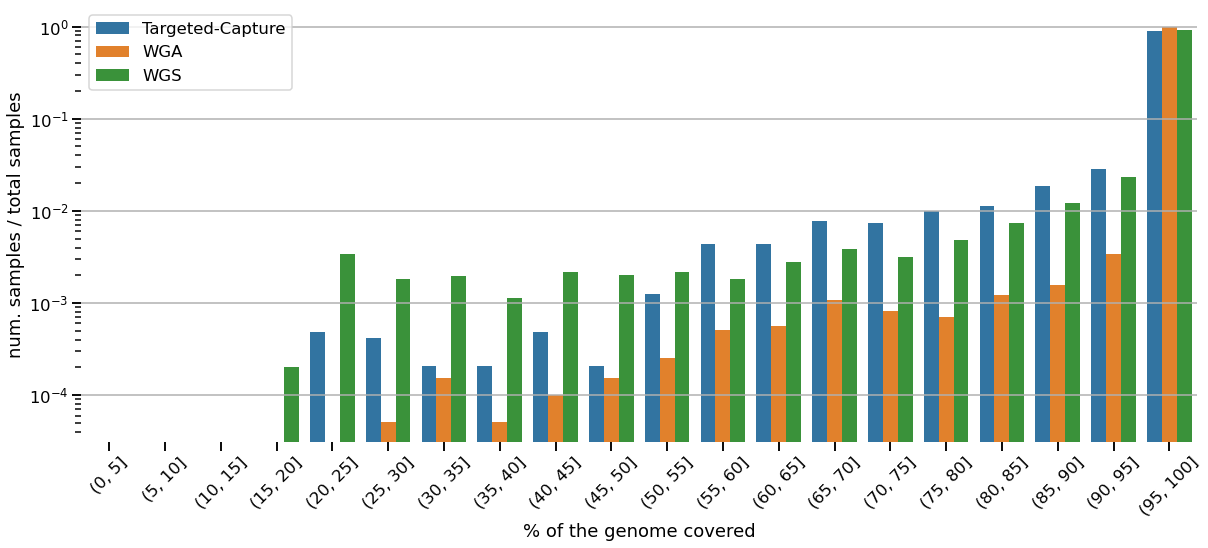

In [103]:
plt.figure(figsize=(20, 8))
sns.barplot(data=num_samples_by_breadth_coverage, 
                x="coverage_binned", y="sample_normalised", hue="library_strategy")
plt.xticks(rotation=45)
plt.title("")
plt.ylabel("num. samples / total samples")
plt.xlabel("% of the genome covered")
plt.legend(title=None)
#plt.grid(axis="x")
plt.grid(axis="y")
plt.yscale("log")
sns.despine(bottom=True, left=True)
plt.savefig("figure_05_bredth_coverage_per_sample_distribution.png")

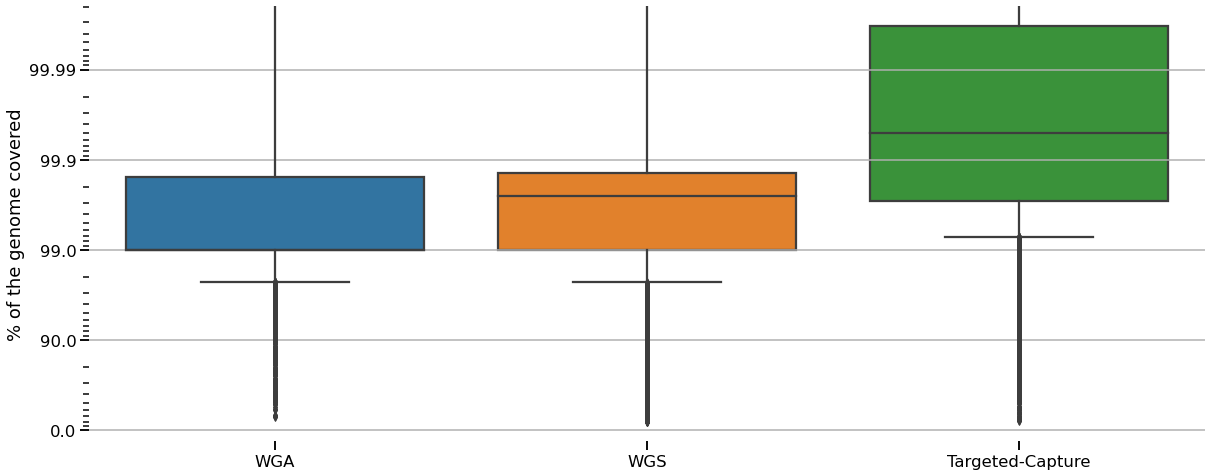

In [138]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=samples, y=100 - samples.coverage, x="library_strategy")
plt.title("")
plt.xlabel(None)
plt.ylabel("% of the genome covered")
plt.grid(axis="y")
plt.yscale("log")
plt.yticks([0.01, 0.1, 1, 10, 100], ["99.99", "99.9", "99.0", "90.0", "0.0"])
plt.gca().invert_yaxis()
sns.despine(bottom=True, left=True)
plt.savefig("figure_05_bredth_coverage_boxplot.png")

In [133]:
samples[samples.library_strategy == "WGA"].coverage.describe()

count    19660.000000
mean        99.047509
std          2.666220
min         27.967100
25%         99.000000
50%         99.000000
75%         99.846200
max        100.000000
Name: coverage, dtype: float64

In [134]:
samples[samples.library_strategy == "WGS"].coverage.describe()

count    14825.000000
mean        97.612148
std          8.799691
min         20.000000
25%         99.000000
50%         99.749200
75%         99.859500
max        100.000000
Name: coverage, dtype: float64

In [137]:
samples[samples.library_strategy == "Targeted-Capture"].coverage.describe()

count    14359.000000
mean        97.891478
std          6.956463
min         20.252100
25%         99.712400
50%         99.949800
75%         99.996700
max        100.000000
Name: coverage, dtype: float64

## Coverage blind spots

The coverage per position data is stored in the file system. Due to performance reasons we sample 1000 samples from the total to read this coverage data.

The median coverage per position is not homogeneous for any library strategy and it drops at the beginning and end of the genome.

All three library strategies show coverage gaps at the end of the genome below 10X from position 29,855, 29,867 and 29,893 for WGA, WGS and targeted capture respectively.
Only WGA and WGS show coverage gaps below 10X at the beginning of the genome until position 38 and 30 respectively.

There are only two internal coverage gaps; a coverage gap below 20X in WGA samples between 22,340 and 22,523; and below 30X there is a small gap  observed in targeted capture samples between positions 21,766 and 21,768. These two gaps are in the N terminal domain. The second gap corresponds to a deletion with high prevalence 21764:ATACATG>A, although this deletion is 6 bp long and not 3 bp. It was confirmed that this deletion was observed irrespective of the library strategy. The first gap is more concerning as it is 183 bp long and lies within the N-terminal domain. 

In [163]:
depth_coverage_sample = os.path.join(local_base_folder, "scratch/info/projects/covigator/data/ena/ERR6360438/ERR6360438.depth.tsv")
sample_depth_coverage = pd.read_csv(depth_coverage_sample, sep="\t", names=["chromosome", "position", "ERR6360438"], skiprows=1)
sample_depth_coverage.head()

,chromosome,position,ERR6360438
0,MN908947.3,32,1
1,MN908947.3,33,1
2,MN908947.3,34,1
3,MN908947.3,35,1
4,MN908947.3,36,1


In [173]:
local_base_folder

'/home/priesgo/tronland'

In [196]:
coverages_list = []
num_samples = 1000
for sample in samples.sample(n=num_samples).run_accession:
    path = local_base_folder + samples[samples.run_accession == sample].vertical_coverage_path.iloc[0]
    data = pd.read_csv(path, sep="\t", names=["chromosome", "position", "count"], skiprows=1)
    del data["chromosome"]
    data["run_accession"] = sample
    coverages_list.append(data)
coverages = pd.concat(coverages_list)
del coverages_list
coverages = pd.merge(coverages, samples[["run_accession", "library_strategy"]], on="run_accession")

In [197]:
coverages.head()

,position,count,run_accession,library_strategy
0,1,52,ERR6346335,Targeted-Capture
1,2,53,ERR6346335,Targeted-Capture
2,3,55,ERR6346335,Targeted-Capture
3,4,57,ERR6346335,Targeted-Capture
4,5,57,ERR6346335,Targeted-Capture


In [199]:
median_coverage_by_position = coverages[["position", "count", "library_strategy"]].groupby(["position", "library_strategy"]).median().reset_index()
median_coverage_by_position.head()

,position,library_strategy,count
0,1,Targeted-Capture,40.0
1,1,WGA,1.0
2,1,WGS,2.0
3,2,Targeted-Capture,41.0
4,2,WGA,1.5


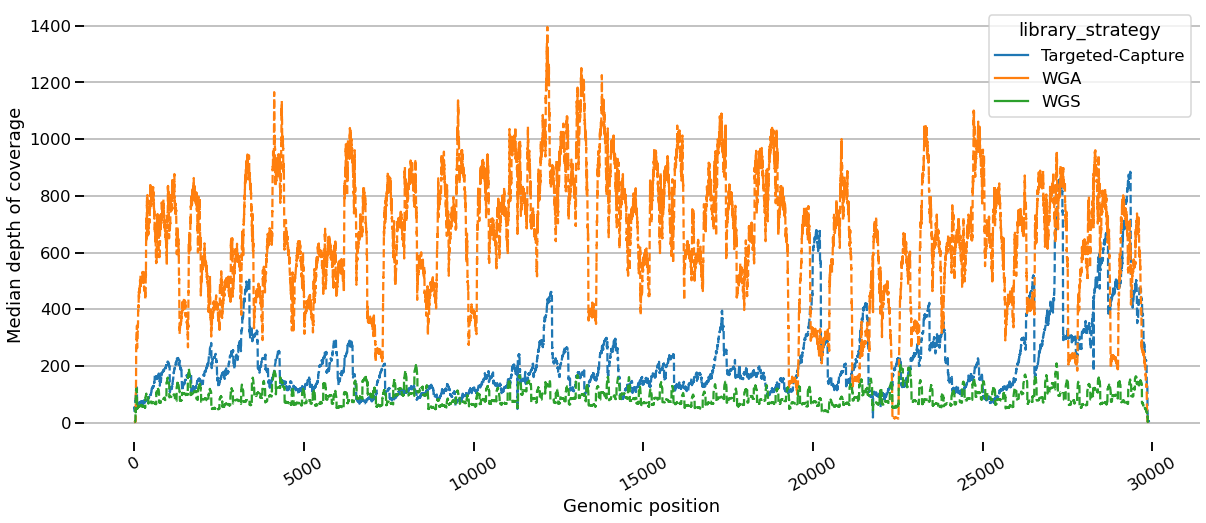

In [194]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=median_coverage_by_position, x="position", y="count", hue="library_strategy", legend=True, linestyle="--")
plt.xticks(rotation=30)
plt.title("n={} samples".format(num_samples))
plt.ylabel("Median depth of coverage")
plt.xlabel("Genomic position")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig("figure_06_coverage_by_position.png")

In [275]:
def get_coverage_gaps(library_strategy = "WGA", coverage_threshold = 10):

    data = median_coverage_by_position[
        (median_coverage_by_position["count"] < coverage_threshold) & 
        (median_coverage_by_position.library_strategy == library_strategy)]
    data["step"] = data.position - data.position.shift(1)
    return data[data.step != 1] #data[data.step != 1] #data[(data.position > 1000) & (data.position < 28000)] #data[data.step != 1]

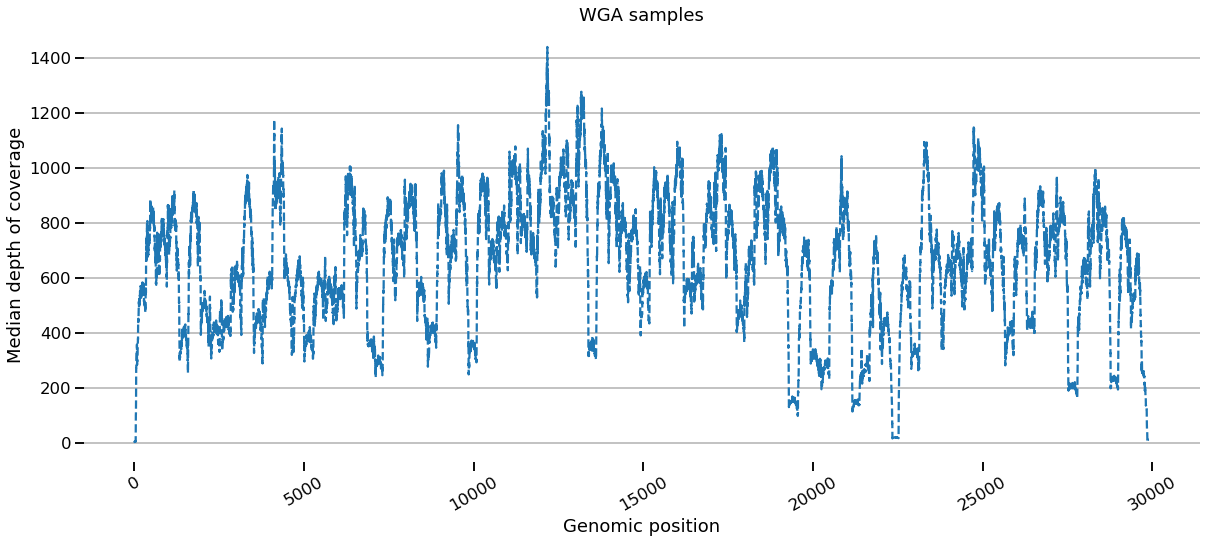

In [229]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=median_coverage_by_position[median_coverage_by_position.library_strategy == "WGA"], 
             x="position", y="count", linestyle="--")
plt.xticks(rotation=30)
plt.title("WGA samples")
plt.ylabel("Median depth of coverage")
plt.xlabel("Genomic position")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig("figure_06_coverage_by_position_wga.png")

In [276]:
get_coverage_gaps(library_strategy = "WGA", coverage_threshold = 10)

,position,library_strategy,count,step
1,1,WGA,1.0,NaN
89563,29855,WGA,9.0,29817.0


In [263]:
get_coverage_gaps(library_strategy = "WGA", coverage_threshold = 20)

,position,library_strategy,count,step
1,1,WGA,1.0,NaN
67018,22340,WGA,18.0,22302.0
67129,22377,WGA,19.0,3.0
67291,22431,WGA,19.0,8.0
67297,22433,WGA,18.0,2.0
89560,29854,WGA,14.0,7331.0


In [262]:
get_coverage_gaps(library_strategy = "WGA", coverage_threshold = 30)

,position,library_strategy,count,step
1,1,WGA,1.0,NaN
67018,22340,WGA,18.0,22302.0
89554,29852,WGA,22.0,7329.0


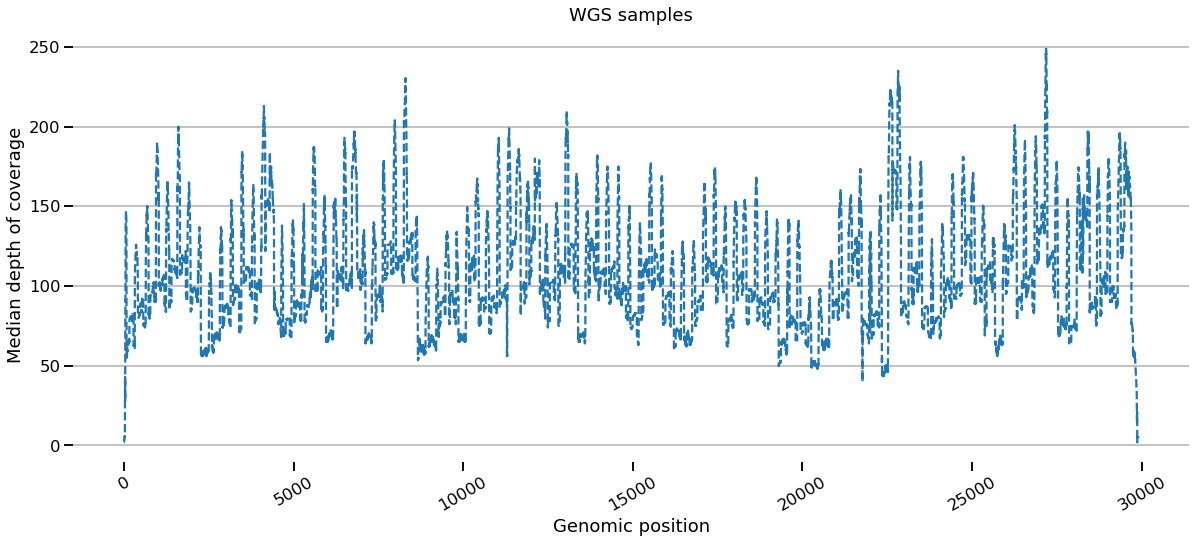

In [230]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=median_coverage_by_position[median_coverage_by_position.library_strategy == "WGS"], 
             x="position", y="count", linestyle="--")
plt.xticks(rotation=30)
plt.title("WGS samples")
plt.ylabel("Median depth of coverage")
plt.xlabel("Genomic position")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig("figure_06_coverage_by_position_wgs.png")

In [277]:
get_coverage_gaps(library_strategy = "WGS", coverage_threshold = 10)

,position,library_strategy,count,step
2,1,WGS,2.0,NaN
89600,29867,WGS,2.0,29837.0


In [265]:
get_coverage_gaps(library_strategy = "WGS", coverage_threshold = 20)

,position,library_strategy,count,step
2,1,WGS,2.0,NaN
89567,29856,WGS,19.0,29826.0
89594,29865,WGS,19.0,4.0


In [266]:
get_coverage_gaps(library_strategy = "WGS", coverage_threshold = 30)

,position,library_strategy,count,step
2,1,WGS,2.0,NaN
113,38,WGS,27.5,8.0
89555,29852,WGS,29.0,29814.0


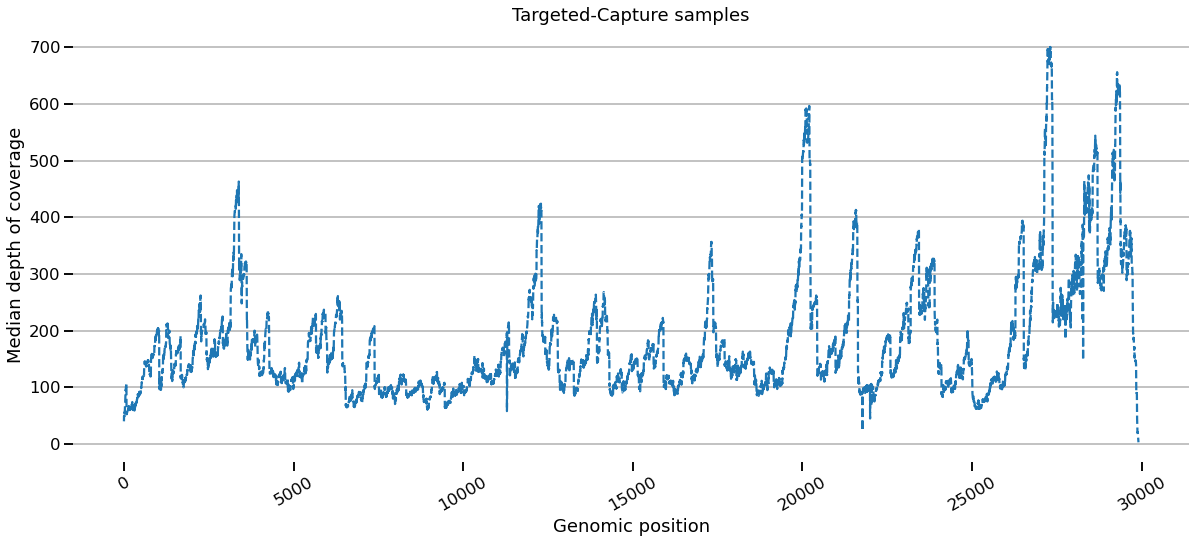

In [231]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=median_coverage_by_position[median_coverage_by_position.library_strategy == "Targeted-Capture"], 
             x="position", y="count", linestyle="--")
plt.xticks(rotation=30)
plt.title("Targeted-Capture samples")
plt.ylabel("Median depth of coverage")
plt.xlabel("Genomic position")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig("figure_06_coverage_by_position_targeted_capture.png")

In [220]:
get_coverage_gaps(library_strategy = "Targeted-Capture", coverage_threshold = 10)

,position,library_strategy,count,step
89676,29893,Targeted-Capture,9.0,NaN


In [221]:
get_coverage_gaps(library_strategy = "Targeted-Capture", coverage_threshold = 20)

,position,library_strategy,count,step
89652,29885,Targeted-Capture,18.0,NaN


In [267]:
get_coverage_gaps(library_strategy = "Targeted-Capture", coverage_threshold = 30)

,position,library_strategy,count,step
65295,21766,Targeted-Capture,26.5,NaN
89598,29867,Targeted-Capture,26.5,8099.0


In [271]:
samples[samples.run_accession.isin(variants[variants.variant_id == "21764:ATACATG>A"]["sample"])].library_strategy.value_counts()

WGA                 4675
WGS                 4059
Targeted-Capture    3016
Name: library_strategy, dtype: int64

In [253]:
max_coverage_by_position = coverages[["position", "count", "library_strategy"]].groupby(["position", "library_strategy"]).max().reset_index()
max_coverage_by_position.head()

,position,library_strategy,count
0,1,Targeted-Capture,1909
1,1,WGA,6
2,1,WGS,2183
3,2,Targeted-Capture,1982
4,2,WGA,12


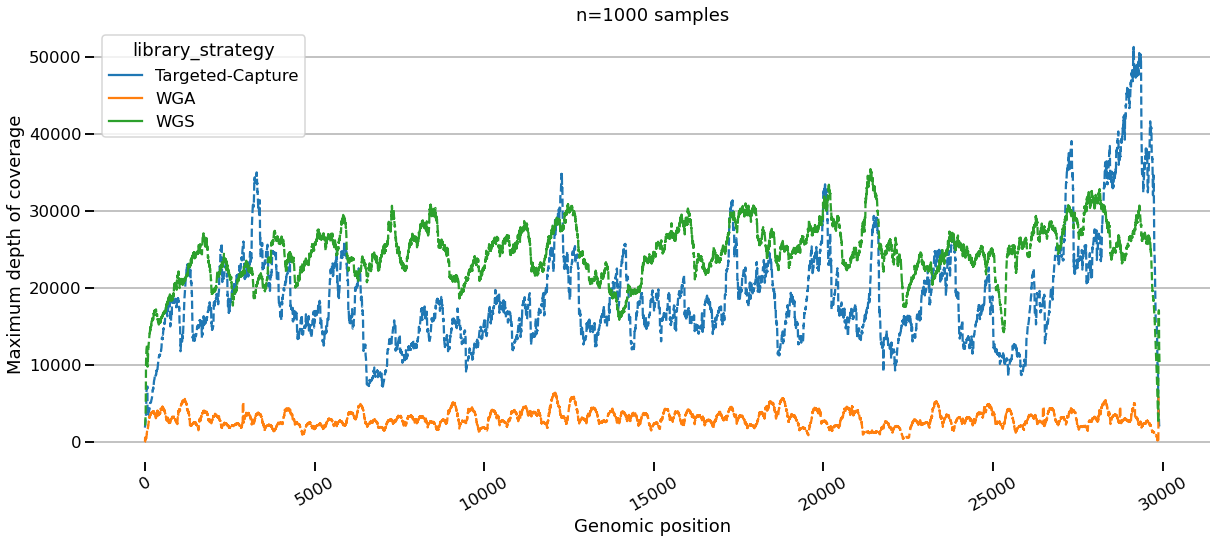

In [201]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=max_coverage_by_position, x="position", y="count", hue="library_strategy", legend=True, linestyle="--")
plt.xticks(rotation=30)
plt.title("n={} samples".format(num_samples))
plt.ylabel("Maximum depth of coverage")
plt.xlabel("Genomic position")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig("figure_06_max_coverage_by_position.png")